In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [5]:
import pandas as pd

# Load dataset
df = pd.read_csv("global_weather.csv")

# Display first few rows
df.head()


country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                    66.2  Partly cloudy  ...                1.1   
2                    73.4          Sunny  ...               10.4   
3                    43.3  Light drizzle  ...                0.7   
4                    78.8  Partly cloudy  ...              183.4   

   air_quality_PM10  air_quality_us-epa-index air_quality_gb-defra-index  \
0              26.6                         1                          1   
1               2.0                         1                          1   
2              18.4                         1                          1   
3               0.9                         1                          1   
4             262.3                         5                         10   

    sunrise    sunset  moonrise   moonset      moon_phase  moon_illumination  
0  04:50 AM  06:50 PM  12:12 PM  01:11 AM  Waxing Gibbous                 55  
1  05:21 AM  07:54 PM  12:58 PM  02:14 AM  Waxing Gibbous                 55  
2  05:40 AM  07:50 PM  01:15 PM  02:14 AM  Waxing Gibbous                 55  
3  06:31 AM  09:11 PM  02:12 PM  03:31 AM  Waxing Gibbous                 55  
4  06:12 AM  05:55 PM  01:17 PM  12:38 AM  Waxing Gibbous                 55  

[5 rows x 41 columns]

In [6]:
# Check for missing values
print(df.isnull().sum())

# Check for duplicate rows
print(f"Duplicate Rows: {df.duplicated().sum()}")


country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Ni

In [7]:
df['lastupdated'] = pd.to_datetime(df['last_updated'])
df.set_index('lastupdated', inplace=True)  # Set as index


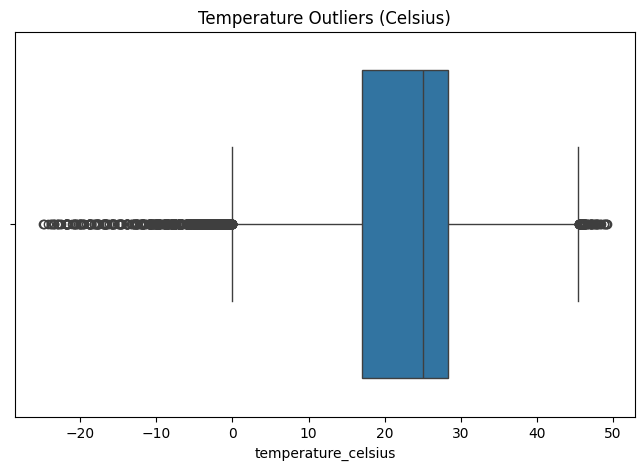

In [8]:
# Box plot for temperature in Celsius
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['temperature_celsius'])
plt.title("Temperature Outliers (Celsius)")
plt.show()


In [9]:
Q1 = df['temperature_celsius'].quantile(0.25)
Q3 = df['temperature_celsius'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['temperature_celsius'] >= lower_bound) & (df['temperature_celsius'] <= upper_bound)]


In [10]:


scaler = MinMaxScaler()
df[['temperature_celsius', 'humidity', 'wind_kph']] = scaler.fit_transform(df[['temperature_celsius', 'humidity', 'wind_kph']])


<ipython-input-10-c77fecfc3f78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['temperature_celsius', 'humidity', 'wind_kph']] = scaler.fit_transform(df[['temperature_celsius', 'humidity', 'wind_kph']])


In [11]:
print(df.describe())


           latitude     longitude  last_updated_epoch  temperature_celsius  \
count  57472.000000  57472.000000        5.747200e+04         57472.000000   
mean      18.457296     21.752829        1.728799e+09             0.502218   
std       24.293890     66.002880        7.582503e+06             0.192953   
min      -41.300000   -175.200000        1.715849e+09             0.000000   
25%        3.170000     -6.840000        1.722342e+09             0.392070   
50%       16.780000     21.433300        1.728726e+09             0.552863   
75%       39.930000     49.882200        1.735296e+09             0.629956   
max       64.150000    179.220000        1.742032e+09             1.000000   

       temperature_fahrenheit      wind_mph      wind_kph   wind_degree  \
count            57472.000000  57472.000000  57472.000000  57472.000000   
mean                73.042788      8.302506      0.003300    168.418900   
std                 15.768011      9.367240      0.005093    103.474253 

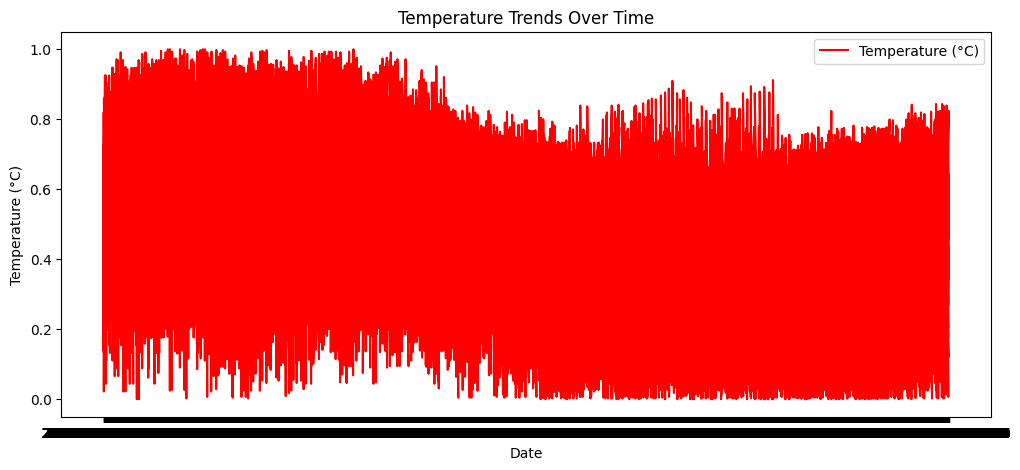

In [12]:

# Plot temperature trend over time
plt.figure(figsize=(12,5))
plt.plot(df['last_updated'], df['temperature_celsius'], label="Temperature (°C)", color='r')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trends Over Time")
plt.legend()
plt.show()


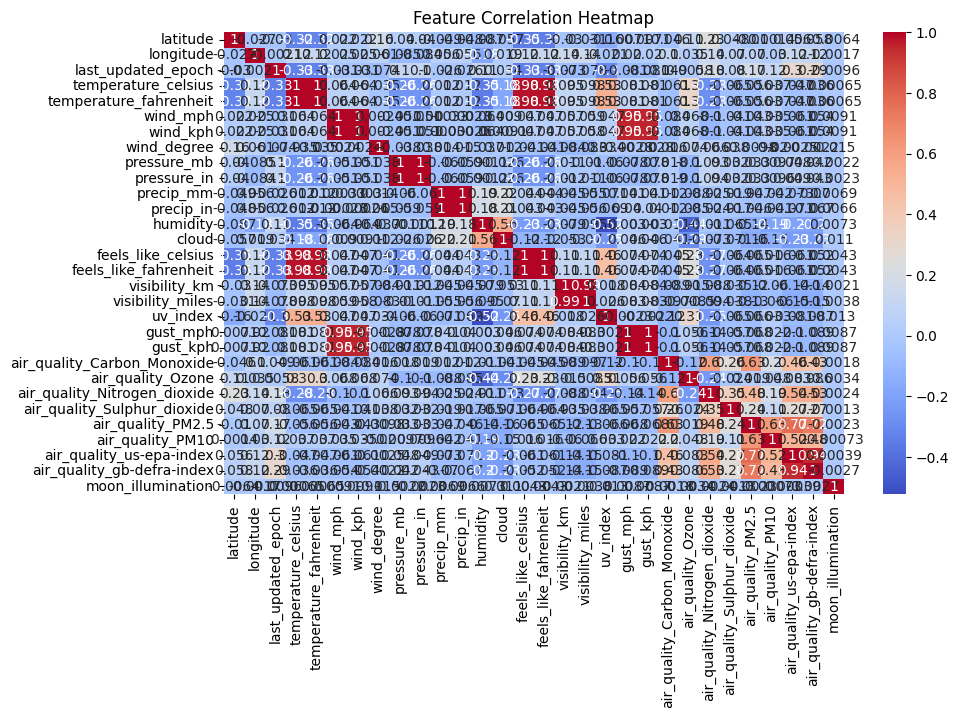

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)

sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

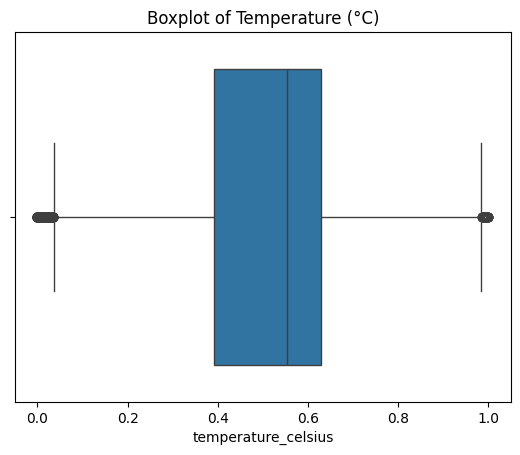

In [14]:
sns.boxplot(x=df['temperature_celsius'])
plt.title("Boxplot of Temperature (°C)")
plt.show()



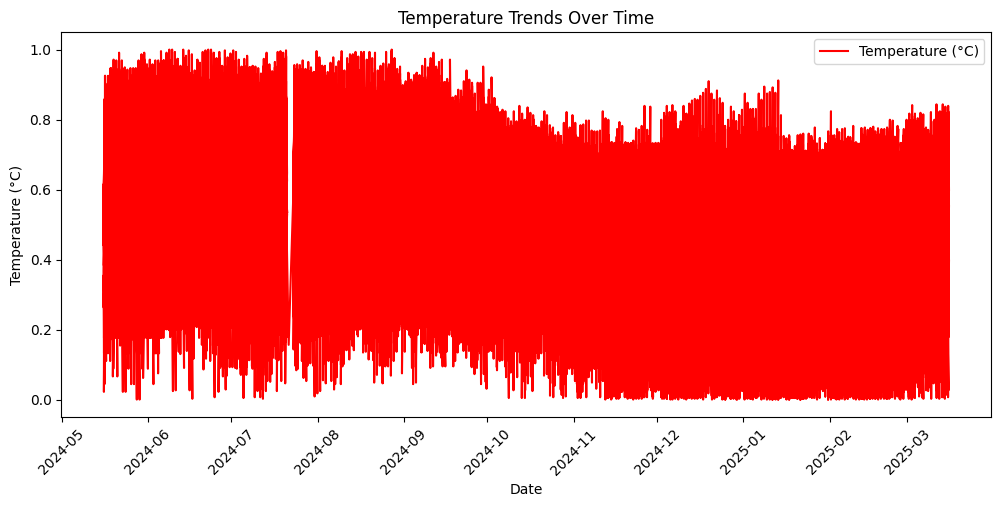

In [15]:
# Convert 'last_updated' to datetime format
df['last_updated'] = pd.to_datetime(df['last_updated'])

# Plot temperature trend over time
plt.figure(figsize=(12, 5))
plt.plot(df['last_updated'], df['temperature_celsius'], label="Temperature (°C)", color='r')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trends Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [16]:
# Ensure last_updated is datetime
df['last_updated'] = pd.to_datetime(df['last_updated'])

# Sort by date
df = df.sort_values(by='last_updated')

# Select features (Temperature Prediction)
features = ['temperature_celsius']
df_lstm = df[features]

# Normalize Data
scaler = MinMaxScaler(feature_range=(0,1))
df_lstm_scaled = scaler.fit_transform(df_lstm)

# Convert data into sequences for LSTM
# (This should be done before splitting the data)
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Define time steps
time_steps = 120

# Create sequences
X, y = create_sequences(df_lstm_scaled, time_steps)

# Ensure dataset is sorted by date before splitting
df = df.sort_values(by="last_updated")

# Now you can split the data into training & testing (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [17]:
# Build LSTM Model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for prediction
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_test, y_test), callbacks=[early_stop])
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 98s 31ms/step - loss: 0.0388 - val_loss: 0.0420
Epoch 2/50
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 89s 31ms/step - loss: 0.0292 - val_loss: 0.0427
Epoch 3/50
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 136s 29ms/step - loss: 864110.7500 - val_loss: 0.0424
Epoch 4/50
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 142s 29ms/step - loss: 0.0284 - val_loss: 0.0419
Epoch 5/50
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 141s 29ms/step - loss: 0.0285 - val_loss: 0.0416
Epoch 6/50
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 142s 29ms/step - loss: 21174944.0000 - val_loss: 0.0431
Epoch 7/50
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 142s 29ms/step - loss: 0.0295 - val_loss: 0.0421
Epoch 8/50
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 142s 29ms/step - loss: 5778519040.0000 - val_loss: 0.0422
Epoch 9/50
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 146s 31ms/step - loss: 0.0304 - val_loss: 0.0421
Epoch 10/50
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 142s 31ms/step - loss: 0.0298 - val_loss: 0.0419
Epoch 1/20
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - loss: 0.0285

359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


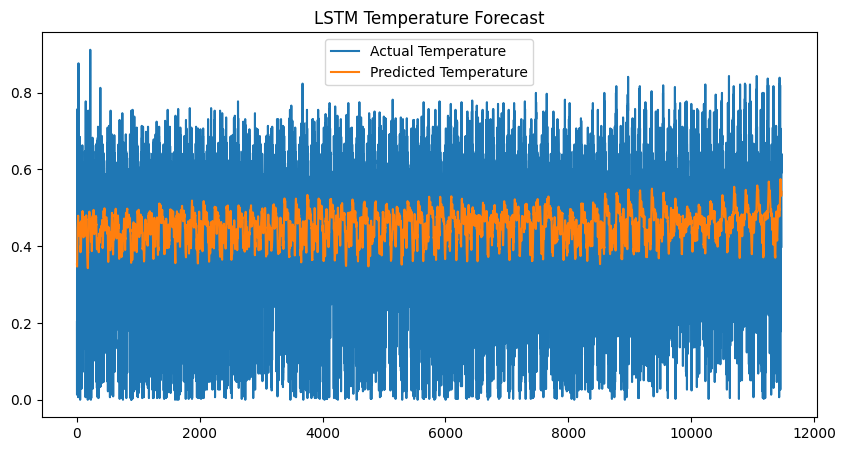

In [18]:
# Predict on test data
y_pred = model.predict(X_test)

# Inverse Transform to get actual temperature values
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

# Plot Predictions vs Actual
plt.figure(figsize=(10,5))
plt.plot(y_test_actual, label="Actual Temperature")
plt.plot(y_pred_actual, label="Predicted Temperature")
plt.legend()
plt.title("LSTM Temperature Forecast")
plt.show()


In [19]:
!pip install prophet


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq24mlv3f/6126zybz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq24mlv3f/11yr399b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32328', 'data', 'file=/tmp/tmpq24mlv3f/6126zybz.json', 'init=/tmp/tmpq24mlv3f/11yr399b.json', 'output', 'file=/tmp/tmpq24mlv3f/prophet_modelec213o5p/prophet_model-20250317182138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


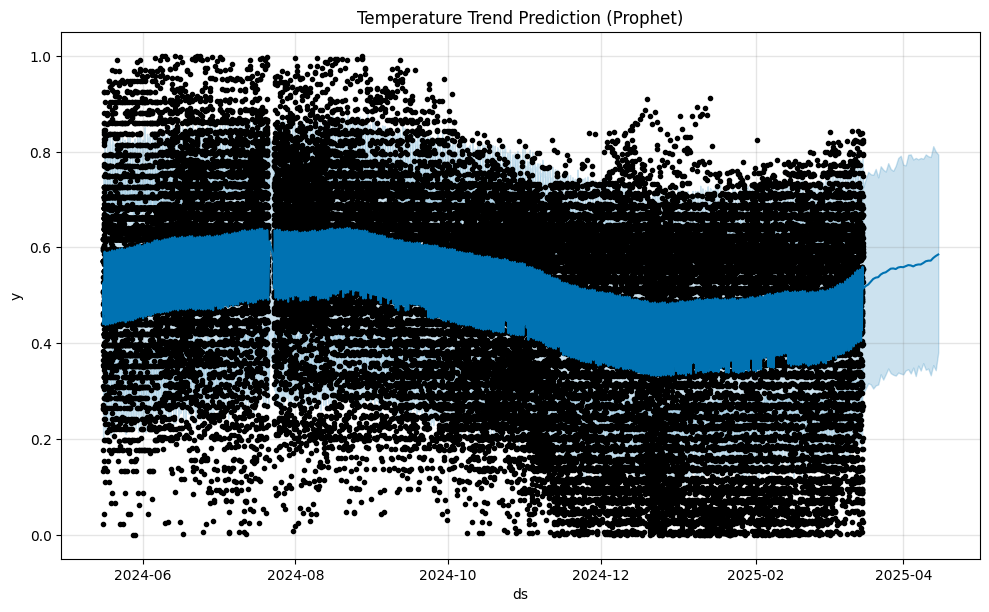

In [20]:
from prophet import Prophet

# Prepare Data
df_prophet = df[['last_updated', 'temperature_celsius']].rename(columns={'last_updated': 'ds', 'temperature_celsius': 'y'})

# Train Prophet Model
model_prophet = Prophet()
model_prophet.add_seasonality(name='yearly', period=365, fourier_order=10)
model_prophet.fit(df_prophet)

# Make Future Predictions
future = model_prophet.make_future_dataframe(periods=30)  # Predict next 30 days
forecast = model_prophet.predict(future)

# Plot Predictions
model_prophet.plot(forecast)
plt.title("Temperature Trend Prediction (Prophet)")
plt.show()


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define optimized LSTM Model
model = Sequential([
    LSTM(150, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),  # Increased units
    Dropout(0.3),  # Increased dropout for regularization
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(50, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Output layer
])

# Compile Model with Lower Learning Rate
optimizer = Adam(learning_rate=0.0005)  # Lower LR for better convergence
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the Optimized Model
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))  # More epochs, smaller batch size


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2868/2868 ━━━━━━━━━━━━━━━━━━━━ 114s 34ms/step - loss: 0.0384 - val_loss: 0.0423
Epoch 2/30
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 90s 31ms/step - loss: 0.0297 - val_loss: 0.0421
Epoch 3/30
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 141s 31ms/step - loss: 0.0290 - val_loss: 0.0430
Epoch 4/30
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 142s 31ms/step - loss: 0.0289 - val_loss: 0.0422
Epoch 5/30
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 94s 33ms/step - loss: 0.0284 - val_loss: 0.0420
Epoch 6/30
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 139s 31ms/step - loss: 0.0281 - val_loss: 0.0418
Epoch 7/30
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 145s 33ms/step - loss: 0.0279 - val_loss: 0.0416
Epoch 8/30
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 142s 33ms/step - loss: 0.0279 - val_loss: 0.0414
Epoch 9/30
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 142s 33ms/step - loss: 0.0274 - val_loss: 0.0417
Epoch 10/30
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 89s 31ms/step - loss: 0.0276 - val_loss: 0.0414
Epoch 11/30
2868/2868 ━━━━━━━━━━━━━━━━━━━━ 147s 33ms/step - loss: 0.0274 - val_loss: 0.0410
Epoch 12/30

359/359 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
Optimized Model - MAE: 0.4276438150678382, RMSE: 0.47573879205557124


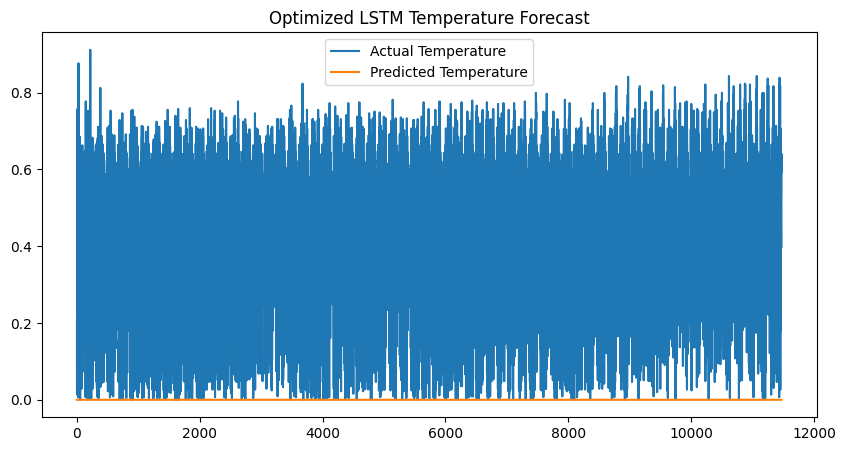

In [23]:
# Predict on test data
y_pred = model.predict(X_test)

# Check for NaN in y_pred
if np.isnan(y_pred).any():
    print("WARNING: NaN values found in model predictions (y_pred).")
    # Handle NaN values in y_pred (e.g., replace with 0 or mean)
    y_pred = np.nan_to_num(y_pred)  # Replace NaN with 0

# Inverse Transform to get actual values
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

# Check for NaN in y_pred_actual and y_test_actual
if np.isnan(y_pred_actual).any() or np.isnan(y_test_actual).any():
    print("WARNING: NaN values found in y_pred_actual or y_test_actual.")
    # Handle NaN values in y_pred_actual or y_test_actual (e.g., remove rows with NaN)
    y_pred_actual = y_pred_actual[~np.isnan(y_pred_actual)]
    y_test_actual = y_test_actual[~np.isnan(y_test_actual)]

# Calculate MAE & RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"Optimized Model - MAE: {mae}, RMSE: {rmse}")

# ... (rest of the code)

# Plot Predictions vs Actual
plt.figure(figsize=(10,5))
plt.plot(y_test_actual, label="Actual Temperature")
plt.plot(y_pred_actual, label="Predicted Temperature")
plt.legend()
plt.title("Optimized LSTM Temperature Forecast")
plt.show()


In [24]:
# Visualize Prophet Predictions
from prophet.plot import plot_plotly
import plotly.graph_objects as go

# Create an interactive forecast plot
fig = plot_plotly(model_prophet, forecast)
fig.update_layout(title="Prophet Forecast: Temperature Trends", xaxis_title="Date", yaxis_title="Temperature (°C)")
fig.show()


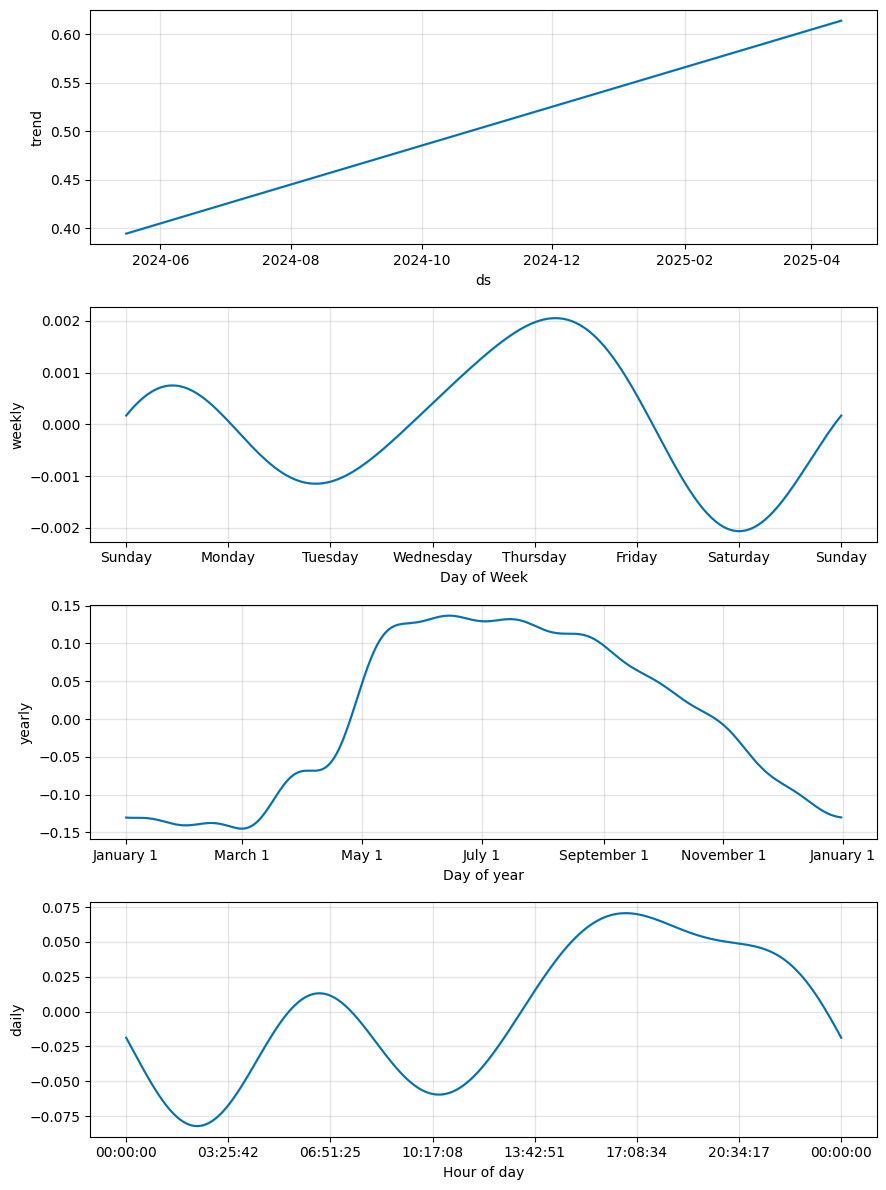

In [25]:
# Show trend, yearly & weekly seasonality
model_prophet.plot_components(forecast)
plt.show()


In [27]:
forecast_df = pd.DataFrame({
    "Actual Temperature (°C)": y_test_actual.flatten(),
    "Predicted Temperature (°C)": y_pred_actual.flatten()
})

# Save to CSV
forecast_df.to_csv("forecast_results.csv", index=False)

print("✅ Forecast results saved as forecast_results.csv")

✅ Forecast results saved as forecast_results.csv
